In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

In [3]:
from sklearn.utils import shuffle
from scipy.special import softmax

In [4]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [5]:
class TorchDataset(Dataset):
    def __init__(self, X, Y, device = 'cpu', X_type = torch.FloatTensor, Y_type = torch.FloatTensor):
        super(TorchDataset, self).__init__()
        self.X = X_type(X).to(device)
        self.Y = Y_type(Y).view([-1, 1]).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [6]:
class HyperModelNN(nn.Module):
    def __init__(self, input_dim = 20, hidden_dim = 10, output_dim = 10, device = 'cpu'):
        super(HyperModelNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        out = input
        out = self.linear1(input)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out
        

In [225]:
class MixtureExpert:
    def __init__(self, n = 10, K = 2, beta = 1, HyperModel = None, device = 'cpu'):
        self.K = K
        self.n = n
        self.device = device
        
        self.beta = beta
        self.W = torch.randn(self.K, self.n, device = self.device)
        if HyperModel is None:
            self.HyperModel = HyperModelNN(input_dim = n, hidden_dim = 10, output_dim = K, device = device)
        else:
            self.HyperModel = HyperModel
        self.pZ = None
        
    def E_step(self, X, Y):
        N = X.shape[0]
        X_tr = torch.torch.FloatTensor(X)
        Y_tr = torch.torch.FloatTensor(Y)
        self.pZ = torch.zeros(N, self.K, device = self.device)
        for i in range(N):
            x = X_tr[i]
            y = Y_tr[i]
            self.pZ[i] = torch.nn.functional.softmax(torch.nn.functional.log_softmax(self.HyperModel(x), dim = -1) - 0.5*self.beta*((y - self.W@x)**2), dim=0).detach()
    
    def M_step(self, X, Y):
        N = X.shape[0]
        X_tr = torch.torch.FloatTensor(X)
        Y_tr = torch.torch.FloatTensor(Y)
# Optimize W
        for k in range(self.K):
            temp1 = 0
            temp2 = 0
            for i in range(N):
                x = X_tr[i]
                y = Y_tr[i]
                z = self.pZ[i][k]
                temp1 += x.view([-1, 1])@x.view([1, -1])*z
                temp2 += y*z*x
            self.W[k] = (torch.inverse(temp1)@temp2.view([-1, 1])).view([-1]).detach()

# Optimize \beta
        temp = float(((((Y_tr.view([-1, 1]) - X_tr@model.W.transpose(0,1))**2)*Z).sum()).detach())
        self.beta = N/float((temp + 0.0001))
            
# Optimize V
        optimizer = torch.optim.Adam(self.HyperModel.parameters())
        dataset = TorchDataset(X_tr, self.pZ, device = device, X_type = torch.FloatTensor, Y_type = torch.FloatTensor)
        for _ in range(10):
            train_generator = DataLoader(dataset = dataset, batch_size = 16, shuffle=True)
            for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
                self.HyperModel.zero_grad()
                loss = -(torch.nn.functional.log_softmax(self.HyperModel(X_tr), dim = -1)*self.pZ).sum()
                loss.backward()
                optimizer.step()
                
    def fit(self, X = None, Y = None, epoch = 10):
        """
        X has a shape [N x n]
        Y has a shape [n]
        """
        if X is None:
            return None
        if y is None:
            return None
        
        for _ in range(epoch):
            self.E_step(X, Y)
            self.M_step(X, Y)
            
        return
    
    def predict(self, X):
        """
        X has a shape [N x n]
        """
        X_tr = torch.torch.FloatTensor(X)
        pi = torch.nn.functional.softmax(self.HyperModel(X_tr), dim = -1).detach()
        
        answ = (X_tr@self.W.transpose(0, 1)).detach()
        
        return (answ*pi).sum(dim = -1).data.numpy()
    

In [226]:
N = 500
n = 3
r1 = 1
r2 = 4
phi = np.linspace(0, 2*np.pi, N)
x = np.hstack([r1*np.sin(phi), r2*np.sin(phi)]) + 0.1*np.random.randn(2*N)
y = np.hstack([r1*np.cos(phi), r2*np.cos(phi)]) + 0.1*np.random.randn(2*N)
# x, y = shuffle(x, y)

X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
Y = x**2+y**2

In [227]:
X.shape, Y.shape

((1000, 3), (1000,))

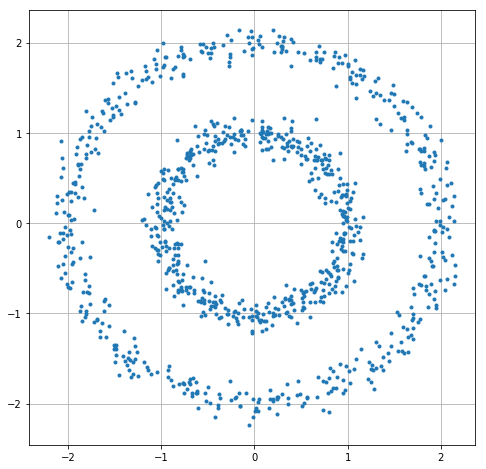

In [228]:
_ = plt.plot(x, y, '.')

plt.grid()
plt.show()

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [230]:
K = 2

HpMd = HyperModelNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device)
model = MixtureExpert(n = n, K = K, beta = 1, HyperModel = HpMd, device = device)

In [256]:
%%time
model.fit(X, Y, 5)

CPU times: user 3.07 s, sys: 44.6 ms, total: 3.11 s
Wall time: 3.13 s


In [257]:
print(model.pZ)

tensor([[7.8110e-17, 1.0000e+00],
        [2.6651e-21, 1.0000e+00],
        [2.7246e-10, 1.0000e+00],
        ...,
        [1.0000e+00, 1.0639e-15],
        [1.0000e+00, 1.4598e-13],
        [1.0000e+00, 1.6421e-18]])


In [258]:
print(model.W)

tensor([[-0.0096, -0.0347,  4.0923],
        [-0.1037, -0.3825,  1.2440]])


In [259]:
print(model.beta)

0.20224381604270134


In [260]:
((model.predict(X)-Y)**2).mean()

0.37799995103703365

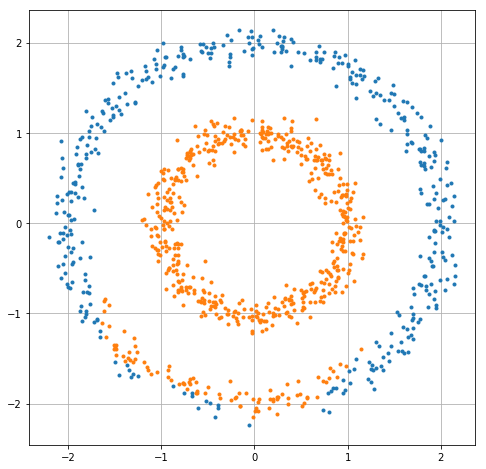

In [261]:
idx = np.argmax(model.pZ.data.numpy(), axis = 1)
for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.')

plt.grid()
plt.show()